In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import talib  # Thư viện cho các chỉ báo kỹ thuật
from datetime import datetime, timedelta
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM
from keras.callbacks import EarlyStopping

# 1. Tải dữ liệu
start = '2010-01-01'
end = datetime.today().strftime('%Y-%m-%d')
stock = 'GOOG'
data = yf.download(stock, start, end)
# Xóa MultiIndex, giữ lại tên cột gốc
data.columns = data.columns.droplevel(1)

# 2. Tính toán các chỉ báo kỹ thuật
data['SMA_50'] = talib.SMA(data['Close'].values, timeperiod=50)
data['EMA_20'] = talib.EMA(data['Close'].values, timeperiod=20)
data['RSI_14'] = talib.RSI(data['Close'].values, timeperiod=14)
data['MACD'], data['MACD_signal'], _ = talib.MACD(data['Close'].values, fastperiod=12, slowperiod=26, signalperiod=9)
data['Upper_BB'], data['Middle_BB'], data['Lower_BB'] = talib.BBANDS(data['Close'].values, timeperiod=20, nbdevup=2, nbdevdn=2)
data['ADX_14'] = talib.ADX(data['High'].values, data['Low'].values, data['Close'].values, timeperiod=14)

# Chỉ báo VWAP
data['VWAP'] = (data['Close'] * data['Volume']).cumsum() / data['Volume'].cumsum()

# Chỉ báo Stochastic Oscillator
data['SlowK'], data['SlowD'] = talib.STOCH(data['High'], data['Low'], data['Close'], fastk_period=14, slowk_period=3, slowd_period=3)

# Chỉ báo CCI (Commodity Channel Index)
data['CCI'] = talib.CCI(data['High'], data['Low'], data['Close'], timeperiod=14)





2025-03-06 08:02:24.184871: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-06 08:02:24.192189: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-06 08:02:24.263362: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-06 08:02:24.318488: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1741222944.371818    7183 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1741222944.39

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


In [4]:
data.dropna(inplace=True)
data.reset_index(inplace=True)

# Chọn các đặc trưng làm đầu vào
features = ['Close', 'SMA_50', 'EMA_20', 'RSI_14', 'MACD', 'MACD_signal', 'Upper_BB', 'Lower_BB', 'ADX_14']
data_train = data[features].iloc[:int(len(data) * 0.80)]
data_test = data[features].iloc[int(len(data) * 0.80):]

# Chuẩn hóa dữ liệu
scaler = MinMaxScaler(feature_range=(0, 1))
data_train_scaled = scaler.fit_transform(data_train)

# 4. Chuẩn bị dữ liệu huấn luyện
x_train, y_train = [], []
for i in range(100, len(data_train_scaled)):
    x_train.append(data_train_scaled[i-100:i])
    y_train.append(data_train_scaled[i, 0])

x_train, y_train = np.array(x_train), np.array(y_train)

# 5. Xây dựng mô hình LSTM
# model = Sequential()
# model.add(LSTM(units=80, activation='relu', return_sequences=True, input_shape=(x_train.shape[1], len(features))))
# model.add(Dropout(0.2))
# model.add(LSTM(units=100, activation='relu', return_sequences=True))
# model.add(Dropout(0.3))
# model.add(LSTM(units=120, activation='relu'))
# model.add(Dropout(0.4))
# model.add(Dense(units=1))
# model.compile(optimizer='adam', loss='mean_squared_error')

model = Sequential()
model.add(LSTM(units=50, activation='relu', return_sequences=True, input_shape=(x_train.shape[1], len(features))))
model.add(Dropout(0.2))
model.add(LSTM(units=80, activation='relu', return_sequences=True))
model.add(Dropout(0.3))
model.add(LSTM(units=120, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')

2025-03-06 08:02:27.835289: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
/home/phung/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [7]:
# # 6. Huấn luyện mô hình
model.fit(x_train, y_train, epochs=5, batch_size=32, verbose=1)
# early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
# model.fit(x_train, y_train, epochs=5, batch_size=32, validation_split=0.2, callbacks=[early_stop])

Epoch 1/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 21s 185ms/step - loss: 0.0372
Epoch 2/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 17s 186ms/step - loss: 0.0035
Epoch 3/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 16s 178ms/step - loss: 0.0035
Epoch 4/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 18s 192ms/step - loss: 0.0022
Epoch 5/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 17s 184ms/step - loss: 0.0025


In [9]:
# 7. Chuẩn bị dữ liệu test
past_100_days = data_train.tail(100)
data_test = pd.concat([past_100_days, data_test], ignore_index=True)
data_test_scaled = scaler.transform(data_test)

x_test, y_test = [], []
for i in range(100, len(data_test_scaled)):
    x_test.append(data_test_scaled[i-100:i])
    y_test.append(data_test_scaled[i, 0])

x_test, y_test = np.array(x_test), np.array(y_test)

# 8. Dự đoán giá cổ phiếu
y_pred = model.predict(x_test)

# 9. Phục hồi giá trị thực
y_pred = y_pred * (1 / scaler.scale_[0])
y_test = y_test * (1 / scaler.scale_[0])

# 10. Dự đoán 30 ngày tiếp theo
future_dates = [data['Date'].iloc[-1] + timedelta(days=i) for i in range(1, 31)]
future_inputs = data_test_scaled[-100:]
predicted_future = []

for _ in range(5):
    future_input = np.array([future_inputs])
    future_price = model.predict(future_input)[0][0]
    predicted_future.append(future_price)
   # future_inputs = np.vstack([future_inputs[1:], np.full((1, future_inputs.shape[1]), future_price)])
future_price_scaled = (future_price - scaler.min_[0]) / scaler.scale_[0]
future_inputs = np.vstack([future_inputs[1:], np.full((1, future_inputs.shape[1]), future_price_scaled)])


predicted_future = np.array(predicted_future) * (1 / scaler.scale_[0])

24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


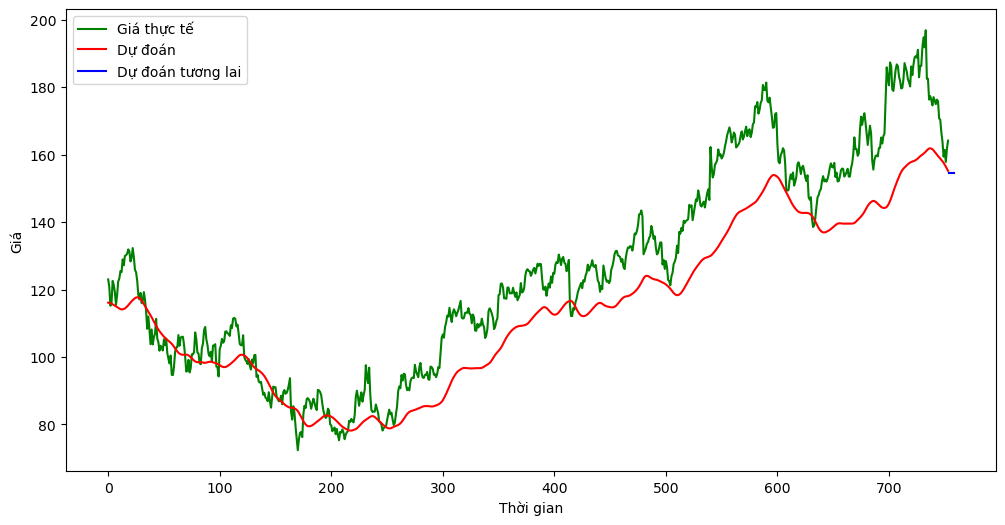

In [13]:
# 11. Vẽ biểu đồ
plt.figure(figsize=(12,6))
plt.plot(y_test, 'g', label='Giá thực tế')
plt.plot(y_pred, 'r', label='Dự đoán')
plt.plot(range(len(y_test), len(y_test) + 5), predicted_future, 'b', label='Dự đoán tương lai')
plt.xlabel('Thời gian')
plt.ylabel('Giá')
plt.legend()
plt.show()